Goal : Test the implementation of the isometries to unitaries functionality in `mps_circuit_helpers.py`

In [67]:
cd ..

/Users/mushahid/Desktop/ProjectFInal


In [68]:
pwd

'/Users/mushahid/Desktop/ProjectFInal'

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import metrics

from MPScumulant import MPS_c
import mps_circuit_helpers
import mps_circuit

In [70]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check the properties of the original trained MPS

In [71]:
m = MPS_c(16)
m.loadMPS('BS-MPS')

# check the properties of the matrices in the MPS
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'BS-MPS'

In [ ]:
mps_circuit_helpers.are_isometries(m)

idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 8) True True
3 (8, 2, 15) True False
4 (15, 2, 16) True False
5 (16, 2, 16) True False
6 (16, 2, 16) True False
7 (16, 2, 15) True False
8 (15, 2, 16) True False
9 (16, 2, 16) True False
10 (16, 2, 16) True False
11 (16, 2, 15) True False
12 (15, 2, 8) True False
13 (8, 2, 4) True False
14 (4, 2, 2) False False
15 (2, 2, 1) False False


Somehow, 14 of the 16 core tensors are left isometries

- does this have something to do with the left-canonicalization performed in the beginning and the training that follows - i guess this is to be found out ?

In [ ]:
%autoreload
mps_unitaries = mps_circuit_helpers.get_mps_unitaries(m)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 8), 4
i = 3, (8, 2, 16), 8
i = 4, (16, 2, 16), 16
i = 5, (16, 2, 16), 16
i = 6, (16, 2, 16), 16
i = 7, (16, 2, 16), 16
i = 8, (16, 2, 16), 16
i = 9, (16, 2, 16), 16
i = 10, (16, 2, 16), 16
i = 11, (16, 2, 16), 16
i = 12, (16, 2, 8), 16
i = 13, (8, 2, 4), 8
i = 14, (4, 2, 2), 4
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


In [ ]:
mps_unitaries


[array([[-2.37179408e-16,  1.84889275e-32, -5.85482703e-32,
         -1.00000000e+00],
        [-5.01014152e-02,  2.22889592e-02,  9.98495393e-01,
          1.18830240e-17],
        [-9.74088684e-01, -2.21860076e-01, -4.39242802e-02,
          2.31033777e-16],
        [-2.20547238e-01,  9.74823732e-01, -3.28269267e-02,
          5.23092632e-17]]),
 array([[-1.00000000e+00, -7.11478724e-22,  4.07515699e-23,
         -5.46929266e-15, -8.43801773e-22, -7.65932089e-22,
          2.18390886e-05,  3.16382712e-06],
        [ 3.89945857e-06, -4.65959879e-01,  1.04360823e-02,
          4.09033873e-01, -5.95060682e-01, -4.61213950e-01,
          1.55959551e-01,  1.55964307e-01],
        [-5.32875403e-10, -4.39511240e-01, -8.43399785e-01,
          2.88816200e-02,  3.01458237e-01,  6.16072747e-02,
         -2.16939307e-05, -1.86797722e-05],
        [-1.72343287e-05, -7.98573632e-02, -1.32428689e-02,
          1.01136192e-01, -1.39538175e-01, -1.16075837e-01,
         -6.89289636e-01, -6.89314293e

In [ ]:
for unitary in mps_unitaries:
    print(mps_circuit_helpers.is_unitary(unitary))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
from pennylane import numpy as pnp
mps_unitaries = pnp.array(mps_unitaries)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [ ]:
mps_unitaries

[array([[-2.37179408e-16,  1.84889275e-32, -5.85482703e-32,
         -1.00000000e+00],
        [-5.01014152e-02,  2.22889592e-02,  9.98495393e-01,
          1.18830240e-17],
        [-9.74088684e-01, -2.21860076e-01, -4.39242802e-02,
          2.31033777e-16],
        [-2.20547238e-01,  9.74823732e-01, -3.28269267e-02,
          5.23092632e-17]]),
 array([[-1.00000000e+00, -7.11478724e-22,  4.07515699e-23,
         -5.46929266e-15, -8.43801773e-22, -7.65932089e-22,
          2.18390886e-05,  3.16382712e-06],
        [ 3.89945857e-06, -4.65959879e-01,  1.04360823e-02,
          4.09033873e-01, -5.95060682e-01, -4.61213950e-01,
          1.55959551e-01,  1.55964307e-01],
        [-5.32875403e-10, -4.39511240e-01, -8.43399785e-01,
          2.88816200e-02,  3.01458237e-01,  6.16072747e-02,
         -2.16939307e-05, -1.86797722e-05],
        [-1.72343287e-05, -7.98573632e-02, -1.32428689e-02,
          1.01136192e-01, -1.39538175e-01, -1.16075837e-01,
         -6.89289636e-01, -6.89314293e

Looks like now we have all we need to begin implementing in pennylane and initialize the actual circuit.

In [ ]:
n_qubits = 5
wire = 1
u_wires = [wire] + list(range(wire+1, wire+n_qubits))
u_wires

[1, 2, 3, 4, 5]

In [ ]:
%autoreload
circuit = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)

In [ ]:
circuit

tensor([2.32537227e-07, 1.16364228e-07, 1.85805691e-07, ...,
        2.07488466e-08, 9.80159871e-13, 1.78652898e-07], requires_grad=True)

Let's try to sample and visualize the data from the model but first let's load and plot the bars and stripes dataset.

In [ ]:
data = np.load('BStest/BSdata.npy')
print(data.shape)
data.dtype

(30, 4, 4)


dtype('bool')

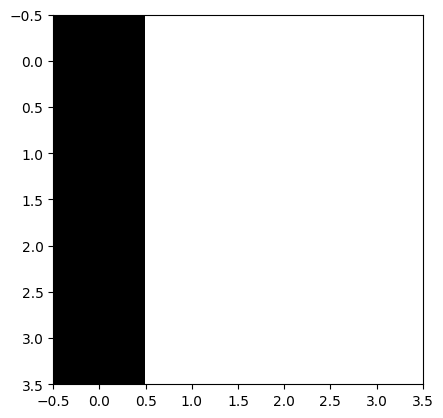

In [ ]:
plt.imshow(data[3], cmap='Greys')

In [ ]:
samples = circuit()

TypeError: 'tensor' object is not callable

In [ ]:
samples.shape

NameError: name 'samples' is not defined

In [ ]:
# check the no. of unique bit-strings
unique_bitstrings, counts = np.unique(samples, return_counts=True, axis=0)

NameError: name 'samples' is not defined

In [ ]:
unique_bitstrings.shape

NameError: name 'unique_bitstrings' is not defined

In [ ]:
a = np.arange(16)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
a.reshape(4, 4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [ ]:
samples = samples.reshape(-1, 4, 4)

In [ ]:
qml.drawer.draw_mpl(circuit)(mps_unitaries)


NameError: name 'circuit' is not defined

In [ ]:
dev = qml.device('default.qubit', wires=16)
@qml.qnode(dev)
def circuit(weights):
    for wire in range(14):
        qml.RX(weights[0], wires=wire)
        qml.RX(weights[1], wires=wire+1)
        qml.RX(weights[2], wires=wire+2)
        # qml.CNOT(wires=[wire,wire+1])
        # qml.CNOT(wires=[wire, wire+2])
        # qml.CNOT(wires=[wire+1,wire+2])
    return qml.probs(wires=list(range(16)))

In [ ]:
from pennylane import numpy as pnp

weights = pnp.random.normal(size=42, requires_grad=True)


In [ ]:
type(circuit)

pennylane.numpy.tensor.tensor

In [ ]:
import metrics
data = np.load('BStest/BSdata.npy')
data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])
filtered_probs = metrics.filter_probs(probs, data)
kl_div = metrics.kl_divergence_estimate(filtered_probs)
print(kl_div)

FileNotFoundError: [Errno 2] No such file or directory: 'BStest/BSdata.npy'

In [ ]:
kl_div = metrics.kl_divergence(probs, data)
print(kl_div)

30.658365798218455


In [ ]:
def loss(mps_unitaries):
    data = np.load('BStest/BSdata.npy')
    data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])      
    probs = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)
    print(probs)
    return metrics.kl_divergence(probs, data)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    mps_unitaries, _loss = opt.step_and_cost(loss, mps_unitaries)
    loss_track.append(_loss)

AttributeError: 'ArrayBox' object has no attribute 'conj'

In [ ]:
cd ..

/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS


In [ ]:
mps_unitaries

tensor([tensor([[-2.37179408e-16,  1.84889275e-32, -5.85482703e-32,
                 -1.00000000e+00],
                [-5.01014152e-02,  2.22889592e-02,  9.98495393e-01,
                  1.18830240e-17],
                [-9.74088684e-01, -2.21860076e-01, -4.39242802e-02,
                  2.31033777e-16],
                [-2.20547238e-01,  9.74823732e-01, -3.28269267e-02,
                  5.23092632e-17]], requires_grad=True)            ,
        tensor([[-1.00000000e+00, -7.11478724e-22,  4.07515699e-23,
                 -5.46929266e-15, -8.43801773e-22, -7.65932089e-22,
                  2.18390886e-05,  3.16382712e-06],
                [ 3.89945857e-06, -4.65959879e-01,  1.04360823e-02,
                  4.09033873e-01, -5.95060682e-01, -4.61213950e-01,
                  1.55959551e-01,  1.55964307e-01],
                [-5.32875403e-10, -4.39511240e-01, -8.43399785e-01,
                  2.88816200e-02,  3.01458237e-01,  6.16072747e-02,
                 -2.16939307e-05, -1.86797

In [ ]:
mps_unitaries[0]

tensor([[-2.37179408e-16,  1.84889275e-32, -5.85482703e-32,
         -1.00000000e+00],
        [-5.01014152e-02,  2.22889592e-02,  9.98495393e-01,
          1.18830240e-17],
        [-9.74088684e-01, -2.21860076e-01, -4.39242802e-02,
          2.31033777e-16],
        [-2.20547238e-01,  9.74823732e-01, -3.28269267e-02,
          5.23092632e-17]], requires_grad=True)

In [ ]:
loss_track

[28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392425902,
 28.534038392

In [ ]:
from pennylane import numpy as pnp
mps_unitaries = pnp.array(mps_unitaries, require_grads=True)

[tensor([[-2.37179408e-16,  1.84889275e-32, -5.85482703e-32,
          -1.00000000e+00],
         [-5.01014152e-02,  2.22889592e-02,  9.98495393e-01,
           1.18830240e-17],
         [-9.74088684e-01, -2.21860076e-01, -4.39242802e-02,
           2.31033777e-16],
         [-2.20547238e-01,  9.74823732e-01, -3.28269267e-02,
           5.23092632e-17]], requires_grad=True),
 tensor([[-1.00000000e+00, -7.11478724e-22,  4.07515699e-23,
          -5.46929266e-15, -8.43801773e-22, -7.65932089e-22,
           2.18390886e-05,  3.16382712e-06],
         [ 3.89945857e-06, -4.65959879e-01,  1.04360823e-02,
           4.09033873e-01, -5.95060682e-01, -4.61213950e-01,
           1.55959551e-01,  1.55964307e-01],
         [-5.32875403e-10, -4.39511240e-01, -8.43399785e-01,
           2.88816200e-02,  3.01458237e-01,  6.16072747e-02,
          -2.16939307e-05, -1.86797722e-05],
         [-1.72343287e-05, -7.98573632e-02, -1.32428689e-02,
           1.01136192e-01, -1.39538175e-01, -1.16075837e-01,

In [ ]:
cd ..

/Users/mushahid/Desktop/ProjectFInal


In [ ]:
cd UnsupGenModbyMps

/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS


In [ ]:
cd BStest


/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS/BStest


In [ ]:
import BS_main as bsmain
BS_main

<module 'BS_main' from '/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS/BStest/BS_main.py'>

In [ ]:
ls

UnboundLocalError: cannot access local variable 'child' where it is not associated with a value

In [ ]:
from pennylane import numpy as np
dev = qml.device('default.qubit', wires=1)
U = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]], requires_grad=True)
f = U.copy()
l = [U, f]
l = np.array(l, requires_grad=True)
@qml.qnode(dev)
def model_1(point, weights):
    qml.AmplitudeEmbedding(point, wires=0, normalize=True)
    qml.QubitUnitary(weights[0], wires=0)
    return qml.expval(qml.PauliX(0))

In [ ]:
l

tensor([[[ 0.5666882 ,  0.64566559],
         [ 0.75968365, -0.43871127]],

        [[ 0.70710678,  0.70710678],
         [ 0.70710678, -0.70710678]]], requires_grad=True)

In [ ]:
from sklearn.datasets import make_blobs
n_samples = 100

X, y = make_blobs(
    n_samples=n_samples, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=6
)

def loss(weights):
    loss_sum = 0.0
    
    for idx in range(n_samples):
        point = X[idx]
        true_expval = y[idx]
        
        estimated_expval = model_1(point, weights)
        loss_sum += (estimated_expval - true_expval) ** 2
        
    return loss_sum / n_samples

In [ ]:
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)
y[y == 0] = -1

In [ ]:
def make_predictions(data, model, weights):
    """Predict the labels of all points in a data set for a given model.
    
    Args:
        data (array[float]): Input data. A list with shape N x 2
            representing points on a 2D plane.
        model (qml.QNode): A QNode whose output expectation value will be
            used to make predictions of the labels of data.
        weights (array[float]): The trainable model parameters for the QNode. 
            
    Returns:
        array[int]: The array of predictions for each data point made by 
        the model QNode. 
    """
    preds = []
    
    for idx in range(len(data)):
        estimated_expval = model(data[idx], weights)
        
        if estimated_expval > 0:
            preds.append(1)
        else:
            preds.append(-1)
            
    return preds

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 20

loss_track = []

for it in range(n_its):
    l, _loss = opt.step_and_cost(loss, l)
    # if it % 5 == 0:
    #     our_preds = make_predictions(X, model_1, weights)
    #     print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
    loss_track.append(_loss)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


In [ ]:
loss_track[-1]

tensor(0.97389343, requires_grad=True)

In [ ]:
def loss(mps_unitaries):
    data = np.load('BStest/BSdata.npy')
    data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])      
    probs = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)
    return metrics.kl_divergence(probs, data)
    

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 2

loss_track = []

for it in range(n_its):
    mps_unitaries, _loss = opt.step_and_cost(loss, mps_unitaries)
 
    loss_track.append(_loss)

AttributeError: 'ArrayBox' object has no attribute 'conj'

In [ ]:
mps_unitaries.shape

(15,)

In [ ]:
mps_unitaries=np.array(mps_unitaries, requires_grad=True)

mps_unitaries_to_circuit(mps_unitaries)

In [ ]:
mps_circuit.mps_unitaries_to_circuit(mps_unitaries)

tensor([2.77580874e-07, 1.26852846e-07, 8.56998948e-09, ...,
        7.87416309e-27, 6.80697370e-29, 7.80561375e-29], requires_grad=True)

In [ ]:
from pennylane import numpy as np
n_wires = len(mps_unitaries) + 1
weights = np.random.normal(size=n_wires * 3, requires_grad=True)
weights


tensor([ 0.12182127,  1.12948391,  1.19891788,  0.18515642, -0.37528495,
        -0.63873041,  0.42349435,  0.07734007, -0.34385368,  0.04359686,
        -0.62000084,  0.69803203, -0.44712856,  1.2245077 ,  0.40349164,
         0.59357852, -1.09491185,  0.16938243,  0.74055645, -0.9537006 ,
        -0.26621851,  0.03261455, -1.37311732,  0.31515939,  0.84616065,
        -0.85951594,  0.35054598, -1.31228341, -0.03869551, -1.61577235,
         1.12141771,  0.40890054, -0.02461696, -0.77516162,  1.27375593,
         1.96710175, -1.85798186,  1.23616403,  1.62765075,  0.3380117 ,
        -1.19926803,  0.86334532, -0.1809203 , -0.60392063, -1.23005814,
         0.5505375 ,  0.79280687, -0.62353073], requires_grad=True)

In [ ]:
pip install optax

  Using cached optax-0.1.4-py3-none-any.whl (154 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached chex-0.1.7-py3-none-any.whl (89 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 2.0 MB/s eta 0:00:0000:01
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tqdm import tqdm 
import jax 
from jax.config import config
from jax import numpy as jnp
import optax
losses = []
weight = jnp.array(np.random.normal(size=n_wires * 3, requires_grad=True))
jitted_grad = jax.jit(jax.grad(loss))
opt_exc = optax.adam(0.1)
opt_state = opt_exc.init(weights)
for it in tqdm(range(3000)):
    grads = jitted_grad(weight)
    grads = grads[0]
    updates, opt_state = opt_exc.update(grads, opt_state)

    weight = optax.apply_updates(weight, updates)


  0%|          | 0/3000 [03:06<?, ?it/s]


TypeError: Expected a callable value, got Traced<ShapedArray(float32[65536])>with<DynamicJaxprTrace(level=4/0)>

In [ ]:
qml.drawer.draw_mpl(circuit)(weights)


IndexError: index 16 is out of bounds for axis 0 with size 16

In [91]:
from pennylane import numpy as pnp
weights = pnp.random.normal(size=(45, 1), requires_grad=True)


In [94]:

# config.update("jax_enable_x64", True)
from tqdm import tqdm 

dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def circuit(weights):
    # # starting from wire 0, apply the multi-qubit unitaries in the list
    # # in a staircase format
    for wire in range(n_wires-1):
        unitary = mps_unitaries[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire+1, wire+n_qubits))
        qml.QubitUnitary(unitary, wires=u_wires)
    i = 0
    while i <= n_wires-3:
        qml.RX(*weights[i], wires=i)
        qml.RX(*weights[i+1], wires=i+1)
        qml.RX(*weights[i+1], wires=i+2)
        qml.CNOT(wires=[i,i+1])
        qml.CNOT(wires=[i,i+2])
        qml.CNOT(wires=[i+1,i+2])
        i+=1

    #     i+=1
    # while i < n_wires-1:
    #     qml.CNOT([i,i+1]
    #              )
    #     i+=1
    # i=0
    # while i < n_wires - 2:
    #     qml.CNOT(wires=[i, i+2])
    #     i+=1
    # i=2
    # while i < n_wires -1:
    #     qml.CNOT(wires=[i, i+1])
    #     i+=1

    return qml.probs(wires=range(n_wires))

def loss(weights):
    data = np.load('BStest/BSdata.npy')
    data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])      
    probs = circuit(weights)
    m = metrics.kl_divergence_estimate(probs)
    return m

opt = qml.GradientDescentOptimizer(stepsize=0.2)

n_its = 10000

loss_track = []
qml.drawer.draw_mpl(circuit)(weights)

for it in tqdm(range(n_its)):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 50 == 0:
        print(_loss)
    loss_track.append(_loss)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
  0%|          | 1/10000 [00:00<2:37:08,  1.06it/s]

0.44855653305750104


  1%|          | 51/10000 [00:37<2:09:02,  1.29it/s]

0.4480730787113827


  1%|          | 101/10000 [01:15<2:04:37,  1.32it/s]

0.4479692113353626


  2%|▏         | 151/10000 [01:54<2:03:35,  1.33it/s]

0.44791597475948974


  2%|▏         | 201/10000 [02:26<2:09:07,  1.26it/s]

0.4478828934925055


  3%|▎         | 251/10000 [02:58<1:39:23,  1.63it/s]

0.4478610758265763


  3%|▎         | 301/10000 [03:31<1:39:54,  1.62it/s]

0.44784615156131447


  4%|▎         | 351/10000 [04:06<2:14:15,  1.20it/s]

0.4478356614311996


  4%|▍         | 401/10000 [06:15<28:35:35, 10.72s/it]

0.447828137662238


  5%|▍         | 451/10000 [12:03<60:49:46, 22.93s/it] 

0.44782264796855237


  5%|▌         | 501/10000 [12:42<1:50:39,  1.43it/s] 

0.44781859345102476


  6%|▌         | 551/10000 [13:20<1:44:45,  1.50it/s]

0.44781556505907105


  6%|▌         | 601/10000 [13:58<2:00:28,  1.30it/s]

0.4478132800978871


  6%|▋         | 628/10000 [14:18<1:52:44,  1.39it/s]

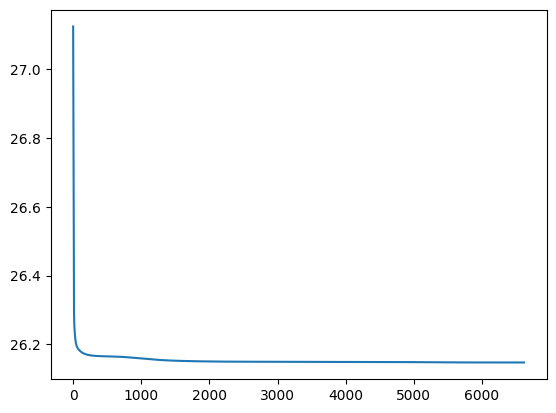

In [88]:
plt.plot(loss_track)

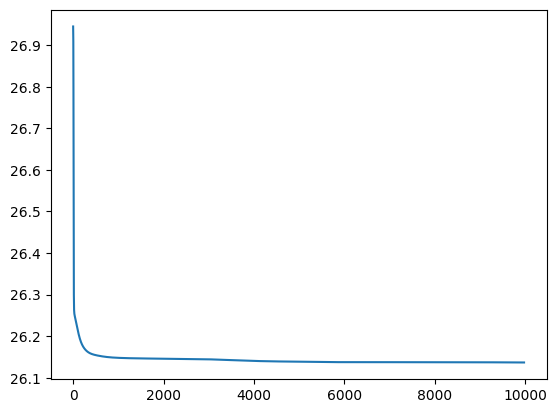

In [80]:
plt.plot(loss_track)

In [ ]:
from pennylane import numpy as pnp
mps_unitaries = pnp.array(mps_unitaries, requires_grad=True)

In [ ]:
for i in range(len())

tensor([[[-6.21511748e-01,  7.77775608e-01, -8.74167611e-02,
           3.38608877e-02],
         [-7.83275954e-01, -6.14868632e-01,  8.34825676e-02,
          -3.80263985e-02],
         [ 1.11672927e-02,  1.20352975e-01,  9.92663188e-01,
           3.20121472e-03],
         [-8.78741637e-03, -5.01680194e-02,  2.96067806e-03,
           9.98697745e-01]],

        [[-9.06135269e-01,  4.13267022e-01, -7.63151095e-02,
          -4.80129859e-02],
         [-4.22817171e-01, -8.88723331e-01,  1.36944886e-01,
           1.12439224e-01],
         [-1.13528741e-02,  1.56334437e-01,  9.87589812e-01,
          -9.84978984e-03],
         [ 3.95300008e-03,  1.22232375e-01, -9.40556165e-03,
           9.92449070e-01]],

        [[-9.74644379e-01,  2.18659014e-01, -2.96860353e-02,
          -3.70851673e-02],
         [-2.22252268e-01, -9.30004725e-01,  1.05789730e-01,
           2.72953612e-01],
         [-5.06887505e-03,  1.09692278e-01,  9.93830746e-01,
          -1.55679151e-02],
         [ 2.5427